In [ ]:
!pip install "qiskit==1.2.4" "qiskit-aer==0.15.1" "qiskit-algorithms==0.3.0"

!pip install qiskit-optimization



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 118.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.5/646.5 kB 13.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.1/237.1 kB 22.8 MB/s eta 0:00:00
  Created wheel for docplex: filename=docplex-2.30.251-py3-none-any.whl size=685954 sha256=545f8e32fa03d5bef6ead5b40c3e8ef1021c949f0a24fc3caf6cb392d7a6e187
  Stored in directory: /root/.c

## Ideal simulator for 10 qubits

In [ ]:

import numpy as np
import heapq
import itertools
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler       
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp

# -------------------------
# Postprocessing helpers
# -------------------------
def parse_state_key(key, n_qubits):
    """Turn a counts key into a binary string of length n_qubits."""
    if isinstance(key, int):
        return format(key, f'0{n_qubits}b')
    if isinstance(key, (tuple, list)):
        return ''.join(str(int(x)) for x in key)
    s = str(key)
    if s.startswith('0b'):
        s = s[2:]
    s = ''.join(ch for ch in s if ch in '01')
    if len(s) == n_qubits:
        return s
    return s.zfill(n_qubits)[-n_qubits:]


def route_min_cost(trip, cost_matrix):
    """Return minimal round-trip cost for a set of patients (patient indices are 1..n)."""
    if not trip:
        return 0.0
    best = float('inf')
    for perm in itertools.permutations(trip):
        c = cost_matrix[0, perm[0]]
        for a, b in zip(perm[:-1], perm[1:]):
            c += cost_matrix[a, b]
        c += cost_matrix[perm[-1], 0]
        if c < best:
            best = c
    return best


def check_constraints_and_decode(bitstr: str, n_patients: int, max_stops: int):
    """
    Given binary string length 2*n_patients:
      bits 0..n-1 -> trip1 flags for patient1..n
      bits n..2n-1 -> trip2 flags for patient1..n
    Return (valid, trip1_list, trip2_list).
    """
    n_qubits = 2 * n_patients
    assert len(bitstr) == n_qubits
    trip1 = []
    trip2 = []
    valid = True
    for i in range(n_patients):
        b1 = int(bitstr[i])
        b2 = int(bitstr[i + n_patients])
        s = b1 + b2
        if s != 1:
            valid = False
        if b1:
            trip1.append(i + 1)
        if b2:
            trip2.append(i + 1)
    if len(trip1) > max_stops or len(trip2) > max_stops:
        valid = False
    return valid, trip1, trip2


def repair_assignment(bitstr: str, n_patients: int, max_stops: int, cost_matrix: np.ndarray):
    """
    Greedy repair:
    - Ensure each patient assigned to exactly one trip
    - Respect capacity by moving extras to the other trip (choose smallest cost increase)
    """
    bits = [int(b) for b in bitstr]
    # ensure one-hot per patient
    for i in range(n_patients):
        b1 = bits[i]
        b2 = bits[i + n_patients]
        if b1 + b2 == 0:
            # assign to the trip with smaller solo cost (rough heuristic)
            cost1 = cost_matrix[0, i + 1] + cost_matrix[i + 1, 0]
            # default assign to trip1 if tie
            bits[i] = 1
            bits[i + n_patients] = 0
        elif b1 + b2 == 2:
            # keep in trip1 as default
            bits[i] = 1
            bits[i + n_patients] = 0

    def current_trips(bits_arr):
        t1 = [i + 1 for i in range(n_patients) if bits_arr[i] == 1]
        t2 = [i + 1 for i in range(n_patients) if bits_arr[i + n_patients] == 1]
        return t1, t2

    t1, t2 = current_trips(bits)

    # fix capacity by moving minimal-impact patients
    while len(t1) > max_stops:
        best_move = None
        best_delta = float('inf')
        for p in t1:
            new_t1 = [x for x in t1 if x != p]
            new_t2 = t2 + [p]
            delta = route_min_cost(new_t1, cost_matrix) + route_min_cost(new_t2, cost_matrix) - (route_min_cost(t1, cost_matrix) + route_min_cost(t2, cost_matrix))
            if delta < best_delta:
                best_delta = delta
                best_move = p
        bits[best_move - 1] = 0
        bits[best_move - 1 + n_patients] = 1
        t1, t2 = current_trips(bits)

    while len(t2) > max_stops:
        best_move = None
        best_delta = float('inf')
        for p in t2:
            new_t2 = [x for x in t2 if x != p]
            new_t1 = t1 + [p]
            delta = route_min_cost(new_t1, cost_matrix) + route_min_cost(new_t2, cost_matrix) - (route_min_cost(t1, cost_matrix) + route_min_cost(t2, cost_matrix))
            if delta < best_delta:
                best_delta = delta
                best_move = p
        bits[best_move - 1 + n_patients] = 0
        bits[best_move - 1] = 1
        t1, t2 = current_trips(bits)

    trip1 = [i + 1 for i in range(n_patients) if bits[i] == 1]
    trip2 = [i + 1 for i in range(n_patients) if bits[i + n_patients] == 1]
    return trip1, trip2


def postprocess_qaoa_counts(counts, cost_matrix, n_patients, max_stops=3, top_k=500):
    """
    counts: quasi_dists dict from sampler.run(...).result().quasi_dists[0]
    Returns best valid assignment (or repaired top sample) with exact route costs.
    """
    n_qubits = 2 * n_patients
    candidates = []
    for key, prob in counts.items():
        s = parse_state_key(key, n_qubits)
        if len(s) != n_qubits:
            continue
        candidates.append((s, float(prob)))
        candidates.append((s[::-1], float(prob)))  # try reversed endianness

    candidates_sorted = sorted(candidates, key=lambda x: -x[1])

    best_valid = None
    best_valid_total_cost = float('inf')
    visited = set()
    for s, prob in candidates_sorted[:top_k]:
        if s in visited:
            continue
        visited.add(s)
        valid, trip1, trip2 = check_constraints_and_decode(s, n_patients, max_stops)
        if not valid:
            continue
        cost1 = route_min_cost(trip1, cost_matrix)
        cost2 = route_min_cost(trip2, cost_matrix)
        total = cost1 + cost2
        if total < best_valid_total_cost:
            best_valid_total_cost = total
            best_valid = {
                "bitstring": s,
                "prob": prob,
                "trip1": trip1,
                "trip2": trip2,
                "trip1_cost": cost1,
                "trip2_cost": cost2,
                "total_cost": total,
                "valid": True
            }

    if best_valid is not None:
        return best_valid

    # no valid sample found -> repair top sample
    if not candidates_sorted:
        raise ValueError("No measured samples available.")
    top_s = candidates_sorted[0][0]
    repaired_t1, repaired_t2 = repair_assignment(top_s, n_patients, max_stops, cost_matrix)
    cost1 = route_min_cost(repaired_t1, cost_matrix)
    cost2 = route_min_cost(repaired_t2, cost_matrix)
    total = cost1 + cost2
    return {
        "bitstring": top_s,
        "prob": candidates_sorted[0][1],
        "trip1": repaired_t1,
        "trip2": repaired_t2,
        "trip1_cost": cost1,
        "trip2_cost": cost2,
        "total_cost": total,
        "valid": False,
        "note": "repaired from top sample"
    }


# -------------------------
# QueueBo optimizer class
# -------------------------
class QueueBoOptimizer:
    def __init__(self, cost_matrix):
        self.cost_matrix = np.array(cost_matrix)
        self.n_patients = len(cost_matrix) - 1
        self.hospital = 0

    def create_sample_cost_matrix(self):
        return self.cost_matrix

    def a_star_classical(self):
        """Classical A* search with max 3 patients per trip (same as before)."""
        def heuristic(remaining_patients, current_pos):
            if not remaining_patients:
                return self.cost_matrix[current_pos][self.hospital]
            total = 0
            for patient in remaining_patients:
                total += min(self.cost_matrix[patient][self.hospital],
                             min([self.cost_matrix[patient][p] for p in remaining_patients if p != patient] + [float('inf')]))
            return total + self.cost_matrix[current_pos][self.hospital]

        start_state = (self.hospital, tuple(), tuple(), 0)
        open_set = [(0, 0, start_state)]
        closed_set = set()
        best_solution, best_cost = None, float('inf')

        while open_set:
            f_score, g_score, state = heapq.heappop(open_set)
            current_pos, visited, current_trip, total_cost = state
            state_key = (current_pos, visited, current_trip)
            if state_key in closed_set:
                continue
            closed_set.add(state_key)

            if len(visited) == self.n_patients:
                final_cost = total_cost + self.cost_matrix[current_pos][self.hospital]
                if final_cost < best_cost:
                    best_cost, best_solution = final_cost, (visited, final_cost)
                continue

            remaining = [i for i in range(1, self.n_patients + 1) if i not in visited]

            if len(current_trip) < 3 and remaining:
                for next_patient in remaining:
                    new_cost = total_cost + self.cost_matrix[current_pos][next_patient]
                    new_visited = tuple(sorted(list(visited) + [next_patient]))
                    new_trip = tuple(sorted(list(current_trip) + [next_patient]))
                    new_state = (next_patient, new_visited, new_trip, new_cost)
                    h_score = heuristic([p for p in range(1, self.n_patients + 1) if p not in new_visited], next_patient)
                    f_score = new_cost + h_score
                    heapq.heappush(open_set, (f_score, new_cost, new_state))

            if current_trip and remaining:
                return_cost = total_cost + self.cost_matrix[current_pos][self.hospital]
                new_state = (self.hospital, visited, tuple(), return_cost)
                h_score = heuristic(remaining, self.hospital)
                f_score = return_cost + h_score
                heapq.heappush(open_set, (f_score, return_cost, new_state))

        return best_solution

    # ---------- QUBO building ----------
    def build_qubo_two_trips(self, P_assign=1000.0, P_cap=500.0):
        """
        Build QUBO matrix for:
          x_i = patient i in trip1 (i=0..n-1)
          y_i = patient i in trip2 (i=n..2n-1)
        Penalties use algebra: (x+y-1)^2 * P_assign  and (sum_trip - K)^2 * P_cap
        Objective uses hospital linear costs + pairwise inter-patient costs.
        """
        n = self.n_patients
        N = 2 * n
        Q = np.zeros((N, N))

        # 1) assignment constraints: (x_i + y_i - 1)^2 * P_assign
        # Expand: P*(1 + 2 x y - x - y) -> linear: -P for x and y; quadratic: 2P for x*y; const: P
        for i in range(n):
            Q[i, i] += -P_assign        # x_i linear
            Q[i + n, i + n] += -P_assign  # y_i linear
            Q[i, i + n] += 2.0 * P_assign  # x_i * y_i coefficient

        # 2) capacity constraints for each trip: (sum - K)^2 * P_cap
        K = 3
        for trip_offset in [0, n]:
            # linear terms from s^2 (sum of x_i) give +1 per x_i, and -2K from -2K*s -> combined: (1 - 2K)
            lin_coef = (1.0 - 2.0 * K) * P_cap
            for i in range(n):
                Q[trip_offset + i, trip_offset + i] += lin_coef
            # quadratic pairwise terms: 2 * P_cap for each pair i<j
            for i in range(n):
                for j in range(i + 1, n):
                    Q[trip_offset + i, trip_offset + j] += 2.0 * P_cap

        # 3) Objective approximations:
        # 3a) hospital in/out linear costs (penalize selecting patient)
        for i in range(n):
            hcost = self.cost_matrix[0, i + 1] + self.cost_matrix[i + 1, 0]
            Q[i, i] += hcost
            Q[n + i, n + i] += hcost

        # 3b) pairwise inter-patient costs added when both patients in same trip
        for i in range(n):
            for j in range(i + 1, n):
                pair_cost = self.cost_matrix[i + 1, j + 1]
                Q[i, j] += pair_cost
                Q[n + i, n + j] += pair_cost

        return Q

    def qubo_to_ising(self, Q):
        """
        Convert QUBO Q (N x N with energy E = sum_i Q[i,i]*x_i + sum_{i<j} Q[i,j]*x_i*x_j)
        to Ising form H = sum_i h_i * Z_i + sum_{i<j} J_ij * Z_i Z_j + const
        using x = (1 - z)/2 mapping.
        """
        N = Q.shape[0]
        a = np.diag(Q).copy()  # linear QUBO a_i
        b = np.triu(Q, k=1).copy()  # upper triangle b_ij

        # constant term: sum_i a_i/2 + sum_{i<j} b_ij/4
        const = 0.5 * np.sum(a) + 0.25 * np.sum(b)

        # h_i = -a_i/2 - sum_{j != i} b_ij / 4
        h = np.zeros(N)
        for i in range(N):
            sum_b = np.sum(Q[i, :]) - Q[i, i]  # sum over j != i of Q[i,j]
            h[i] = -0.5 * a[i] - 0.25 * sum_b

        # J_ij = b_ij / 4 for i<j
        pauli_list = []
        coeffs = []
        # linear Z terms
        for i in range(N):
            if abs(h[i]) > 0:
                pa = ['I'] * N
                pa[i] = 'Z'
                pauli_list.append(''.join(pa))
                coeffs.append(h[i])
        # quadratic ZZ terms
        for i in range(N):
            for j in range(i + 1, N):
                if abs(Q[i, j]) > 1e-12:
                    J = 0.25 * Q[i, j]
                    pa = ['I'] * N
                    pa[i] = 'Z'
                    pa[j] = 'Z'
                    pauli_list.append(''.join(pa))
                    coeffs.append(J)

        sparse = SparsePauliOp.from_list(list(zip(pauli_list, coeffs)))
        return sparse, const

    def solve_quantum_qaoa(self, reps=2, maxiter=100):
        """Full QAOA flow with postprocessing to exact route costs."""
        Q = self.build_qubo_two_trips(P_assign=1000.0, P_cap=500.0)
        hamiltonian, constant = self.qubo_to_ising(Q)

        optimizer = COBYLA(maxiter=maxiter)
        sampler = Sampler()   # using Aer sampler (deprecated warning may appear)
        qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=reps)

        # Run QAOA -> result has optimal parameters / eigenstate info
        result = qaoa.compute_minimum_eigenvalue(operator=hamiltonian)
        optimal_value = result.optimal_value + constant
        print(f"QAOA reported energy (ising): {result.optimal_value:.6f}  (+const {constant:.6f} -> {optimal_value:.6f})")

        # Build the ansatz circuit with found parameters and sample it
        try:
            qc = qaoa.ansatz.assign_parameters(result.optimal_parameters)
        except Exception:
            
            qc = qaoa.ansatz.bind_parameters(result.optimal_parameters)

        # Run sampler to get measurement distribution
        job = sampler.run([qc])
        qc_counts = job.result().quasi_dists[0]  
        # qc_counts may be dict mapping int/bitstring/tuple -> probability

        # Postprocess counts to find valid assignment and exact route costs
        res = postprocess_qaoa_counts(qc_counts, self.cost_matrix, self.n_patients, max_stops=3)

        
        print("Decoded quantum result:")
        print("  Bitstring:", res["bitstring"])
        print("  Measured prob:", res["prob"])
        print(f"  Trip 1 patients: {res['trip1']}  cost = {res['trip1_cost']:.4f}")
        print(f"  Trip 2 patients: {res['trip2']}  cost = {res['trip2_cost']:.4f}")
        print(f"  Total two-trip cost: {res['total_cost']:.4f}")
        print("  Valid measured sample (satisfies constraints):", res.get("valid", False))
        if not res.get("valid", True):
            print("  Note:", res.get("note"))

        return {
            "success": True,
            "quantum_energy": float(result.optimal_value),
            "quantum_energy_with_const": float(optimal_value),
            "decoded": res
        }

    def solve_and_compare(self):
        print("QueueBo: Smart Traffic Optimization")
        print("=" * 50)
        print("\nCost Matrix (Hospital=0, Patients=1-5):")
        print(self.cost_matrix)

        print("\n1. CLASSICAL A* APPROACH:")
        print("-" * 30)
        classical_result = self.a_star_classical()
        if classical_result:
            visited_order, total_cost = classical_result
            print(f"Optimal route order: {visited_order}")
            print(f"Total cost: {total_cost}")
        else:
            print("No solution found with classical approach")

        print("\n2. QUANTUM QAOA APPROACH (2-trip encoded):")
        print("-" * 30)
        quantum_result = self.solve_quantum_qaoa(reps=2, maxiter=100)
        return {"classical": classical_result, "quantum": quantum_result}


# -------------------------
# Run demo
# -------------------------
if __name__ == "__main__":
    print("Initializing QueueBo Smart Traffic Optimization System...")
    cost_matrix = np.array([
        [0.0, 8.63, 11.5, 9.45, 10.85, 9.67],
        [14.19, 0.0, 2.36, 10.92, 9.24, 9.43],
        [17.78, 7.75, 0.0, 11.81, 10.12, 10.48],
        [11.86, 19.67, 15.66, 0.0, 11.57, 11.54],
        [7.34, 12.17, 10.05, 4.07, 0.0, 5.93],
        [9.27, 9.4, 12.27, 7.32, 8.72, 0.0]
    ])
    optimizer = QueueBoOptimizer(cost_matrix)
    _ = optimizer.solve_and_compare()


Initializing QueueBo Smart Traffic Optimization System...
QueueBo: Smart Traffic Optimization

Cost Matrix (Hospital=0, Patients=1-5):
[[ 0.    8.63 11.5   9.45 10.85  9.67]
 [14.19  0.    2.36 10.92  9.24  9.43]
 [17.78  7.75  0.   11.81 10.12 10.48]
 [11.86 19.67 15.66  0.   11.57 11.54]
 [ 7.34 12.17 10.05  4.07  0.    5.93]
 [ 9.27  9.4  12.27  7.32  8.72  0.  ]]

1. CLASSICAL A* APPROACH:
------------------------------
Optimal route order: (1, 2, 3, 4, 5)
Total cost: 57.3

2. QUANTUM QAOA APPROACH (2-trip encoded):
------------------------------


/tmp/ipython-input-3644152536.py:419: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  quantum_result = self.solve_quantum_qaoa(reps=2, maxiter=100)


QAOA reported energy (ising): -1860.540503  (+const -9842.760000 -> -11703.300503)
Decoded quantum result:
  Bitstring: 0010111010
  Measured prob: 0.001953125
  Trip 1 patients: [3, 5]  cost = 28.8500
  Trip 2 patients: [1, 2, 4]  cost = 28.4500
  Total two-trip cost: 57.3000
  Valid measured sample (satisfies constraints): True


# Ideal Simulation for 100 itration

Initializing QueueBo Smart Traffic Optimization System...
QueueBo: Smart Traffic Optimization

Cost Matrix (Hospital=0, Patients=1-5):
[[ 0.    8.63 11.5   9.45 10.85  9.67]
 [14.19  0.    2.36 10.92  9.24  9.43]
 [17.78  7.75  0.   11.81 10.12 10.48]
 [11.86 19.67 15.66  0.   11.57 11.54]
 [ 7.34 12.17 10.05  4.07  0.    5.93]
 [ 9.27  9.4  12.27  7.32  8.72  0.  ]]

1. CLASSICAL A* APPROACH:
------------------------------
Optimal route order: (1, 2, 3, 4, 5)
Total cost: 57.3

2. QUANTUM QAOA APPROACH (2-trip encoded, sampling):
------------------------------


/tmp/ipython-input-1197530130.py:454: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  quantum_result = self.solve_quantum_qaoa(reps=2, maxiter=300, n_samples=n_samples)


QAOA reported energy (ising): -497.453252  (+const -9842.760000 -> -10340.213252)

Top observed total-costs (km) and frequencies:
  57.300 km  -  48 occurrences
  63.090 km  -  17 occurrences
  57.520 km  -  15 occurrences
  68.240 km  -  5 occurrences
  66.370 km  -  3 occurrences
  64.880 km  -  3 occurrences
  66.200 km  -  3 occurrences
  68.230 km  -  2 occurrences
  65.050 km  -  2 occurrences
  60.390 km  -  2 occurrences


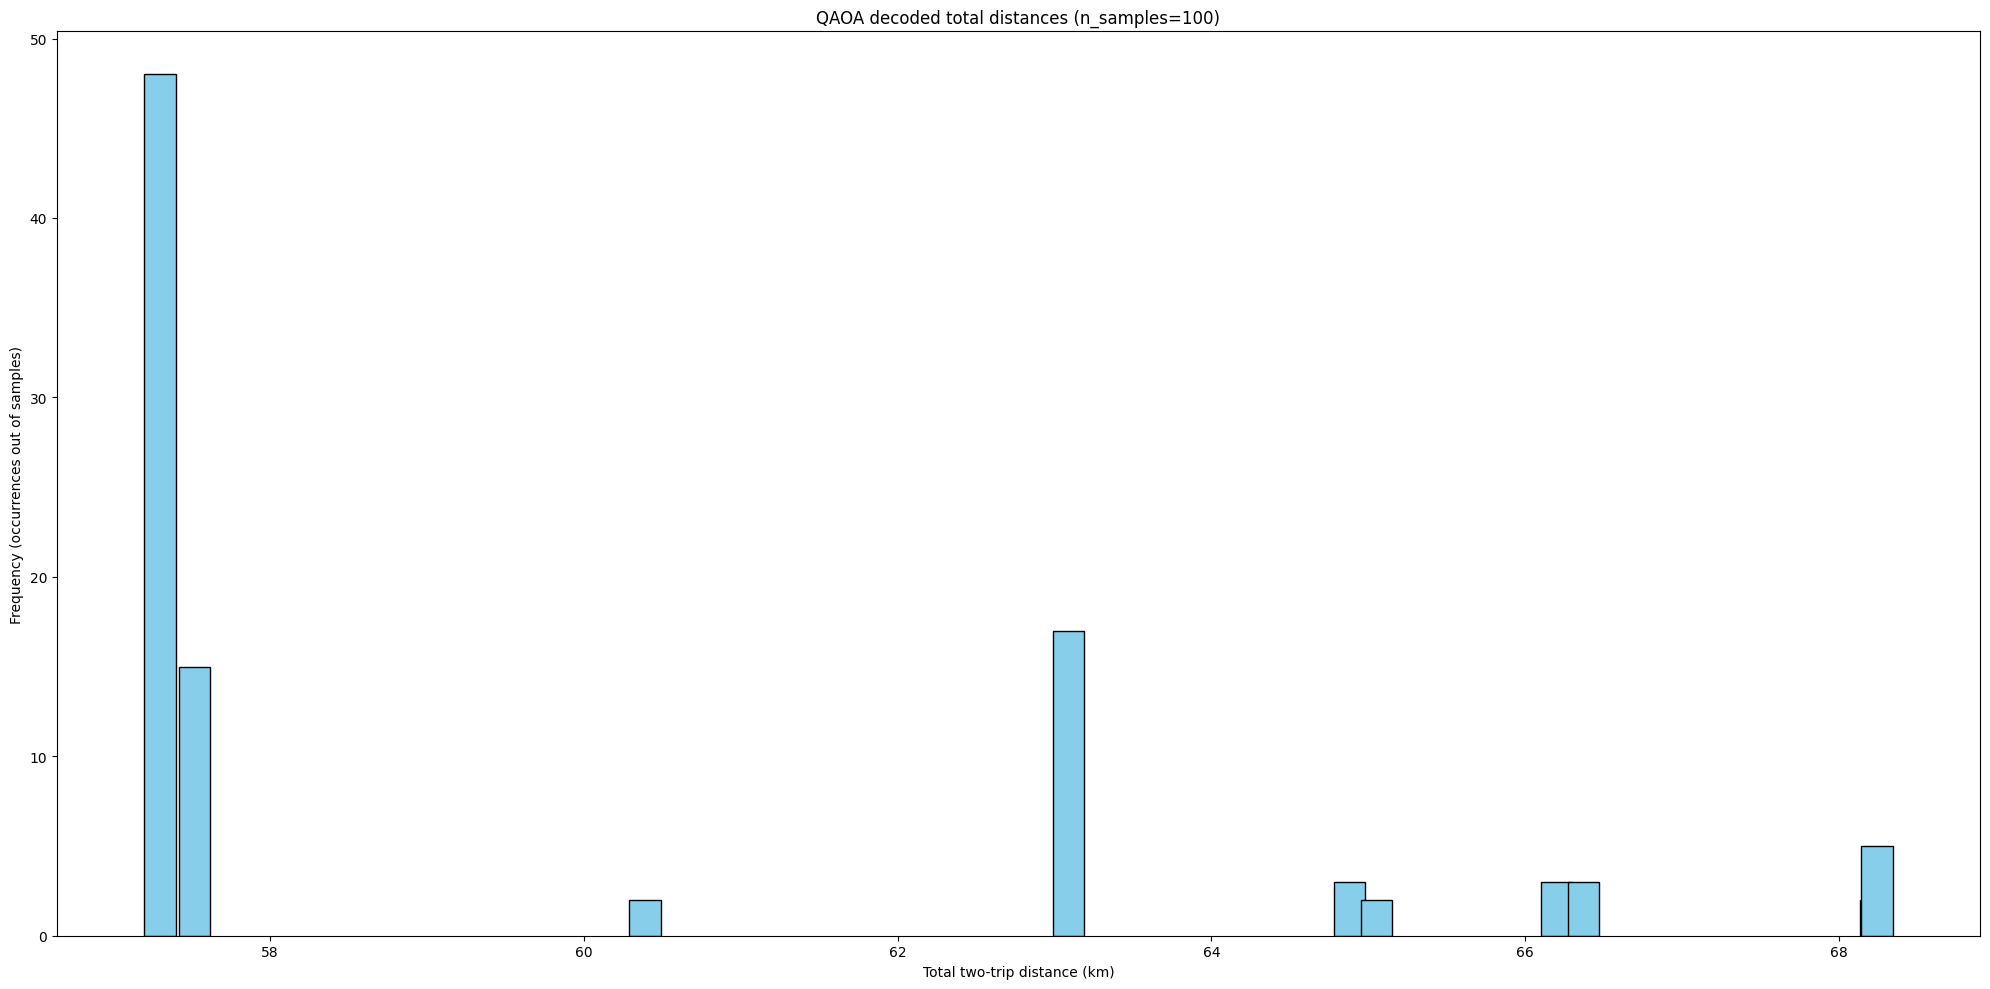

In [ ]:

import numpy as np
import heapq
import itertools
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler         
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp

# -------------------------
# Postprocessing helpers (unchanged, with small util for decoding single sample)
# -------------------------
def parse_state_key(key, n_qubits):
    """Turn a counts key into a binary string of length n_qubits."""
    if isinstance(key, int):
        return format(key, f'0{n_qubits}b')
    if isinstance(key, (tuple, list)):
        return ''.join(str(int(x)) for x in key)
    s = str(key)
    if s.startswith('0b'):
        s = s[2:]
    s = ''.join(ch for ch in s if ch in '01')
    if len(s) == n_qubits:
        return s
    return s.zfill(n_qubits)[-n_qubits:]


def route_min_cost(trip, cost_matrix):
    """Return minimal round-trip cost for a set of patients (patient indices are 1..n)."""
    if not trip:
        return 0.0
    best = float('inf')
    for perm in itertools.permutations(trip):
        c = cost_matrix[0, perm[0]]
        for a, b in zip(perm[:-1], perm[1:]):
            c += cost_matrix[a, b]
        c += cost_matrix[perm[-1], 0]
        if c < best:
            best = c
    return best


def check_constraints_and_decode(bitstr: str, n_patients: int, max_stops: int):
    """
    Given binary string length 2*n_patients:
      bits 0..n-1 -> trip1 flags for patient1..n
      bits n..2n-1 -> trip2 flags for patient1..n
    Return (valid, trip1_list, trip2_list).
    """
    n_qubits = 2 * n_patients
    assert len(bitstr) == n_qubits
    trip1 = []
    trip2 = []
    valid = True
    for i in range(n_patients):
        b1 = int(bitstr[i])
        b2 = int(bitstr[i + n_patients])
        s = b1 + b2
        if s != 1:
            valid = False
        if b1:
            trip1.append(i + 1)
        if b2:
            trip2.append(i + 1)
    if len(trip1) > max_stops or len(trip2) > max_stops:
        valid = False
    return valid, trip1, trip2


def repair_assignment(bitstr: str, n_patients: int, max_stops: int, cost_matrix: np.ndarray):
    """
    Greedy repair:
    - Ensure each patient assigned to exactly one trip
    - Respect capacity by moving extras to the other trip (choose smallest cost increase)
    """
    bits = [int(b) for b in bitstr]
    # ensure one-hot per patient
    for i in range(n_patients):
        b1 = bits[i]
        b2 = bits[i + n_patients]
        if b1 + b2 == 0:
            # assign to the trip with smaller solo cost (rough heuristic)
            # default assign to trip1 if tie
            bits[i] = 1
            bits[i + n_patients] = 0
        elif b1 + b2 == 2:
            # keep in trip1 as default
            bits[i] = 1
            bits[i + n_patients] = 0

    def current_trips(bits_arr):
        t1 = [i + 1 for i in range(n_patients) if bits_arr[i] == 1]
        t2 = [i + 1 for i in range(n_patients) if bits_arr[i + n_patients] == 1]
        return t1, t2

    t1, t2 = current_trips(bits)

    # fix capacity by moving minimal-impact patients
    while len(t1) > max_stops:
        best_move = None
        best_delta = float('inf')
        for p in t1:
            new_t1 = [x for x in t1 if x != p]
            new_t2 = t2 + [p]
            delta = route_min_cost(new_t1, cost_matrix) + route_min_cost(new_t2, cost_matrix) - (route_min_cost(t1, cost_matrix) + route_min_cost(t2, cost_matrix))
            if delta < best_delta:
                best_delta = delta
                best_move = p
        bits[best_move - 1] = 0
        bits[best_move - 1 + n_patients] = 1
        t1, t2 = current_trips(bits)

    while len(t2) > max_stops:
        best_move = None
        best_delta = float('inf')
        for p in t2:
            new_t2 = [x for x in t2 if x != p]
            new_t1 = t1 + [p]
            delta = route_min_cost(new_t1, cost_matrix) + route_min_cost(new_t2, cost_matrix) - (route_min_cost(t1, cost_matrix) + route_min_cost(t2, cost_matrix))
            if delta < best_delta:
                best_delta = delta
                best_move = p
        bits[best_move - 1 + n_patients] = 0
        bits[best_move - 1] = 1
        t1, t2 = current_trips(bits)

    trip1 = [i + 1 for i in range(n_patients) if bits[i] == 1]
    trip2 = [i + 1 for i in range(n_patients) if bits[i + n_patients] == 1]
    return trip1, trip2


def postprocess_qaoa_counts(counts, cost_matrix, n_patients, max_stops=3, top_k=500):
    """
    counts: quasi_dists dict from sampler.run(...).result().quasi_dists[0]
    Returns best valid assignment (or repaired top sample) with exact route costs.
    """
    n_qubits = 2 * n_patients
    candidates = []
    for key, prob in counts.items():
        s = parse_state_key(key, n_qubits)
        if len(s) != n_qubits:
            continue
        candidates.append((s, float(prob)))
        candidates.append((s[::-1], float(prob)))  # try reversed endianness

    candidates_sorted = sorted(candidates, key=lambda x: -x[1])

    best_valid = None
    best_valid_total_cost = float('inf')
    visited = set()
    for s, prob in candidates_sorted[:top_k]:
        if s in visited:
            continue
        visited.add(s)
        valid, trip1, trip2 = check_constraints_and_decode(s, n_patients, max_stops)
        if not valid:
            continue
        cost1 = route_min_cost(trip1, cost_matrix)
        cost2 = route_min_cost(trip2, cost_matrix)
        total = cost1 + cost2
        if total < best_valid_total_cost:
            best_valid_total_cost = total
            best_valid = {
                "bitstring": s,
                "prob": prob,
                "trip1": trip1,
                "trip2": trip2,
                "trip1_cost": cost1,
                "trip2_cost": cost2,
                "total_cost": total,
                "valid": True
            }

    if best_valid is not None:
        return best_valid

    # no valid sample found -> repair top sample
    if not candidates_sorted:
        raise ValueError("No measured samples available.")
    top_s = candidates_sorted[0][0]
    repaired_t1, repaired_t2 = repair_assignment(top_s, n_patients, max_stops, cost_matrix)
    cost1 = route_min_cost(repaired_t1, cost_matrix)
    cost2 = route_min_cost(repaired_t2, cost_matrix)
    total = cost1 + cost2
    return {
        "bitstring": top_s,
        "prob": candidates_sorted[0][1],
        "trip1": repaired_t1,
        "trip2": repaired_t2,
        "trip1_cost": cost1,
        "trip2_cost": cost2,
        "total_cost": total,
        "valid": False,
        "note": "repaired from top sample"
    }


# -------------------------
# QueueBo optimizer class (modified to aggregate samples and plot histogram)
# -------------------------
class QueueBoOptimizer:
    def __init__(self, cost_matrix):
        self.cost_matrix = np.array(cost_matrix)
        self.n_patients = len(cost_matrix) - 1
        self.hospital = 0

    def create_sample_cost_matrix(self):
        return self.cost_matrix

    # (a_star_classical and build_qubo_two_trips, qubo_to_ising remain unchanged)
    def a_star_classical(self):
        def heuristic(remaining_patients, current_pos):
            if not remaining_patients:
                return self.cost_matrix[current_pos][self.hospital]
            total = 0
            for patient in remaining_patients:
                total += min(self.cost_matrix[patient][self.hospital],
                             min([self.cost_matrix[patient][p] for p in remaining_patients if p != patient] + [float('inf')]))
            return total + self.cost_matrix[current_pos][self.hospital]

        start_state = (self.hospital, tuple(), tuple(), 0)
        open_set = [(0, 0, start_state)]
        closed_set = set()
        best_solution, best_cost = None, float('inf')

        while open_set:
            f_score, g_score, state = heapq.heappop(open_set)
            current_pos, visited, current_trip, total_cost = state
            state_key = (current_pos, visited, current_trip)
            if state_key in closed_set:
                continue
            closed_set.add(state_key)

            if len(visited) == self.n_patients:
                final_cost = total_cost + self.cost_matrix[current_pos][self.hospital]
                if final_cost < best_cost:
                    best_cost, best_solution = final_cost, (visited, final_cost)
                continue

            remaining = [i for i in range(1, self.n_patients + 1) if i not in visited]

            if len(current_trip) < 3 and remaining:
                for next_patient in remaining:
                    new_cost = total_cost + self.cost_matrix[current_pos][next_patient]
                    new_visited = tuple(sorted(list(visited) + [next_patient]))
                    new_trip = tuple(sorted(list(current_trip) + [next_patient]))
                    new_state = (next_patient, new_visited, new_trip, new_cost)
                    h_score = heuristic([p for p in range(1, self.n_patients + 1) if p not in new_visited], next_patient)
                    f_score = new_cost + h_score
                    heapq.heappush(open_set, (f_score, new_cost, new_state))

            if current_trip and remaining:
                return_cost = total_cost + self.cost_matrix[current_pos][self.hospital]
                new_state = (self.hospital, visited, tuple(), return_cost)
                h_score = heuristic(remaining, self.hospital)
                f_score = return_cost + h_score
                heapq.heappush(open_set, (f_score, return_cost, new_state))

        return best_solution

    def build_qubo_two_trips(self, P_assign=1000.0, P_cap=500.0):
        n = self.n_patients
        N = 2 * n
        Q = np.zeros((N, N))

        for i in range(n):
            Q[i, i] += -P_assign
            Q[i + n, i + n] += -P_assign
            Q[i, i + n] += 2.0 * P_assign

        K = 3
        for trip_offset in [0, n]:
            lin_coef = (1.0 - 2.0 * K) * P_cap
            for i in range(n):
                Q[trip_offset + i, trip_offset + i] += lin_coef
            for i in range(n):
                for j in range(i + 1, n):
                    Q[trip_offset + i, trip_offset + j] += 2.0 * P_cap

        for i in range(n):
            hcost = self.cost_matrix[0, i + 1] + self.cost_matrix[i + 1, 0]
            Q[i, i] += hcost
            Q[n + i, n + i] += hcost

        for i in range(n):
            for j in range(i + 1, n):
                pair_cost = self.cost_matrix[i + 1, j + 1]
                Q[i, j] += pair_cost
                Q[n + i, n + j] += pair_cost

        return Q

    def qubo_to_ising(self, Q):
        N = Q.shape[0]
        a = np.diag(Q).copy()
        b = np.triu(Q, k=1).copy()
        const = 0.5 * np.sum(a) + 0.25 * np.sum(b)
        h = np.zeros(N)
        for i in range(N):
            sum_b = np.sum(Q[i, :]) - Q[i, i]
            h[i] = -0.5 * a[i] - 0.25 * sum_b

        pauli_list = []
        coeffs = []
        for i in range(N):
            if abs(h[i]) > 0:
                pa = ['I'] * N
                pa[i] = 'Z'
                pauli_list.append(''.join(pa))
                coeffs.append(h[i])
        for i in range(N):
            for j in range(i + 1, N):
                if abs(Q[i, j]) > 1e-12:
                    J = 0.25 * Q[i, j]
                    pa = ['I'] * N
                    pa[i] = 'Z'
                    pa[j] = 'Z'
                    pauli_list.append(''.join(pa))
                    coeffs.append(J)

        sparse = SparsePauliOp.from_list(list(zip(pauli_list, coeffs)))
        return sparse, const

    # ---- sample many times and aggregate decoded km values ----
    def solve_quantum_qaoa(self, reps=2, maxiter=300, n_samples=100):
        """
        Full QAOA flow with postprocessing to exact route costs.
        n_samples: number of measurement shots (samples) to aggregate.
        Returns: dict with summary and samples_hist (mapping rounded_km -> count).
        """
        Q = self.build_qubo_two_trips(P_assign=1000.0, P_cap=500.0)
        hamiltonian, constant = self.qubo_to_ising(Q)

        optimizer = COBYLA(maxiter=maxiter)
        sampler = Sampler()   # using Aer sampler
        qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=reps)

        # Compute optimal parameters / eigenvalue
        result = qaoa.compute_minimum_eigenvalue(operator=hamiltonian)
        optimal_value = result.optimal_value + constant
        print(f"QAOA reported energy (ising): {result.optimal_value:.6f}  (+const {constant:.6f} -> {optimal_value:.6f})")

        # Build the ansatz circuit with found parameters and sample it
        try:
            qc = qaoa.ansatz.assign_parameters(result.optimal_parameters)
        except Exception:
            qc = qaoa.ansatz.bind_parameters(result.optimal_parameters)

        # Try to request all samples in one run (shots=n_samples).
        try:
            job = sampler.run([qc], shots=n_samples)
            qc_quasi = job.result().quasi_dists[0]  # dict: key -> probability
            # Convert to integer counts (approx) by multiplying probabilities by n_samples
            sample_counts = {}
            for k, p in qc_quasi.items():
                cnt = int(round(float(p) * n_samples))
                if cnt <= 0:
                    continue
                sample_counts[k] = cnt
        except Exception:
            # Fallback: run sampler n_samples times with shots=1
            sample_counts = {}
            for _ in range(n_samples):
                job = sampler.run([qc])  # default single-shot
                qc_quasi = job.result().quasi_dists[0]
                # pick highest-prob outcome from this single-shot quasi-dist
                # convert quasi-dist to most-likely key
                if not qc_quasi:
                    continue
                # qc_quasi mapping may have probs but single-shot; choose max key
                best_key = max(qc_quasi.items(), key=lambda x: x[1])[0]
                sample_counts[best_key] = sample_counts.get(best_key, 0) + 1

        # Now decode each sampled key into trips and exact total cost,
        # and aggregate counts over rounded km values.
        samples_hist = {}  # rounded_km -> count
        detailed_samples = []  # optional list of (bitstr, valid, trip1, trip2, cost, count)
        n_qubits = 2 * self.n_patients

        for key, cnt in sample_counts.items():
            bitstr = parse_state_key(key, n_qubits)
            # try both endiannesses: as-is and reversed
            valid, trip1, trip2 = check_constraints_and_decode(bitstr, self.n_patients, max_stops=3)
            used_bitstr = bitstr
            if not valid:
                # try reversed
                valid_r, trip1_r, trip2_r = check_constraints_and_decode(bitstr[::-1], self.n_patients, max_stops=3)
                if valid_r:
                    valid, trip1, trip2 = valid_r, trip1_r, trip2_r
                    used_bitstr = bitstr[::-1]
                else:
                    # repair if still invalid
                    repaired_t1, repaired_t2 = repair_assignment(bitstr, self.n_patients, max_stops=3, cost_matrix=self.cost_matrix)
                    trip1, trip2 = repaired_t1, repaired_t2
                    valid = False  # repaired
                    used_bitstr = bitstr

            cost1 = route_min_cost(trip1, self.cost_matrix)
            cost2 = route_min_cost(trip2, self.cost_matrix)
            total = cost1 + cost2
            # round to a sensible precision for histogram keys (e.g., 3 decimals)
            key_km = round(float(total), 3)
            samples_hist[key_km] = samples_hist.get(key_km, 0) + cnt
            detailed_samples.append((used_bitstr, valid, trip1, trip2, total, cnt))

        # Print top few decoded solutions
        top_sorted = sorted(samples_hist.items(), key=lambda x: -x[1])
        print("\nTop observed total-costs (km) and frequencies:")
        for cost_km, c in top_sorted[:10]:
            print(f"  {cost_km:.3f} km  -  {c} occurrences")

        # Plot histogram of observed total-costs
        if samples_hist:
            x = sorted(samples_hist.keys())
            y = [samples_hist[k] for k in x]
            plt.figure(figsize=(20,10))
            plt.bar(x, y, width=0.2, color = "skyblue",edgecolor='black')
            plt.xlabel("Total two-trip distance (km)")
            plt.ylabel("Frequency (occurrences out of samples)")
            plt.title(f"QAOA decoded total distances (n_samples={n_samples})")
            plt.tight_layout()
            plt.show()
        else:
            print("No samples collected to plot.")

        return {
            "success": True,
            "quantum_energy": float(result.optimal_value),
            "quantum_energy_with_const": float(optimal_value),
            "samples_hist": samples_hist,
            "detailed_samples": detailed_samples
        }

    def solve_and_compare(self, n_samples=100):
        print("QueueBo: Smart Traffic Optimization")
        print("=" * 50)
        print("\nCost Matrix (Hospital=0, Patients=1-5):")
        print(self.cost_matrix)

        print("\n1. CLASSICAL A* APPROACH:")
        print("-" * 30)
        classical_result = self.a_star_classical()
        if classical_result:
            visited_order, total_cost = classical_result
            print(f"Optimal route order: {visited_order}")
            print(f"Total cost: {total_cost}")
        else:
            print("No solution found with classical approach")

        print("\n2. QUANTUM QAOA APPROACH (2-trip encoded, sampling):")
        print("-" * 30)
        quantum_result = self.solve_quantum_qaoa(reps=2, maxiter=300, n_samples=n_samples)
        return {"classical": classical_result, "quantum": quantum_result}


# -------------------------
# Run demo
# -------------------------
if __name__ == "__main__":
    print("Initializing QueueBo Smart Traffic Optimization System...")
    cost_matrix = np.array([
        [0.0, 8.63, 11.5, 9.45, 10.85, 9.67],
        [14.19, 0.0, 2.36, 10.92, 9.24, 9.43],
        [17.78, 7.75, 0.0, 11.81, 10.12, 10.48],
        [11.86, 19.67, 15.66, 0.0, 11.57, 11.54],
        [7.34, 12.17, 10.05, 4.07, 0.0, 5.93],
        [9.27, 9.4, 12.27, 7.32, 8.72, 0.0]
    ])
    optimizer = QueueBoOptimizer(cost_matrix)
    res = optimizer.solve_and_compare(n_samples=100)  # <-- run with 100 samples


# Noise simulation 100 itrations


=== Iteration 1/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 2/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 3/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 4/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 5/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 6/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 7/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 8/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 9/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 10/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 11/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 12/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 13/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 14/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 15/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 16/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 17/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 18/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 19/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 20/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 21/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 22/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 23/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 24/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 25/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 26/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 27/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 28/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 29/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 30/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 31/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 32/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 33/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 34/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 35/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 36/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 37/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 38/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 39/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 40/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 41/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 42/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 43/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 44/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 45/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 46/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 47/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 48/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 49/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 50/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 51/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 52/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 53/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 54/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 55/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 56/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 57/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 58/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 59/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 60/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 61/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 62/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 63/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 64/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 65/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 66/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 67/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 68/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 69/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 70/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 71/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 72/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 73/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 74/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 75/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 76/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 77/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 78/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 79/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 80/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 81/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 82/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 83/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 84/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 85/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 86/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 87/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 88/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 89/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 90/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 91/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 92/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 93/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 94/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 95/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 96/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 97/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 98/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 99/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



=== Iteration 100/100 ===


/tmp/ipython-input-769611944.py:80: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)


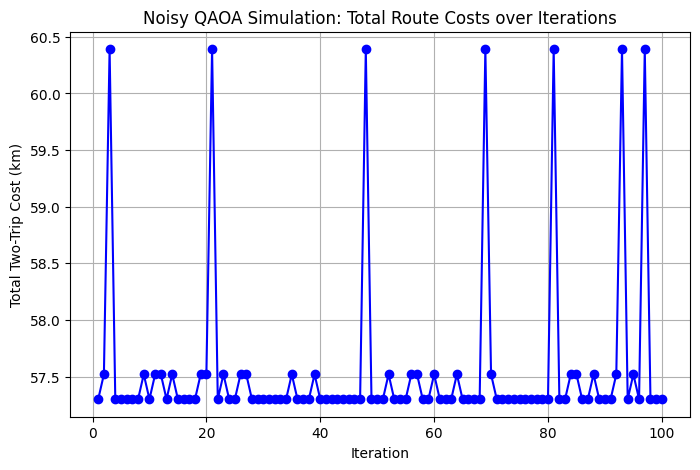

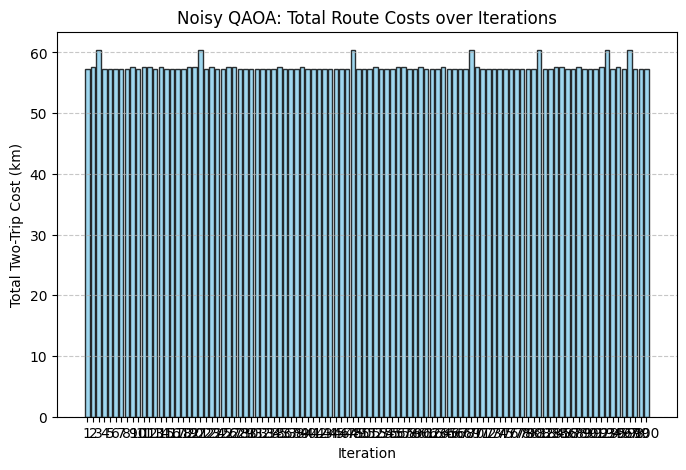

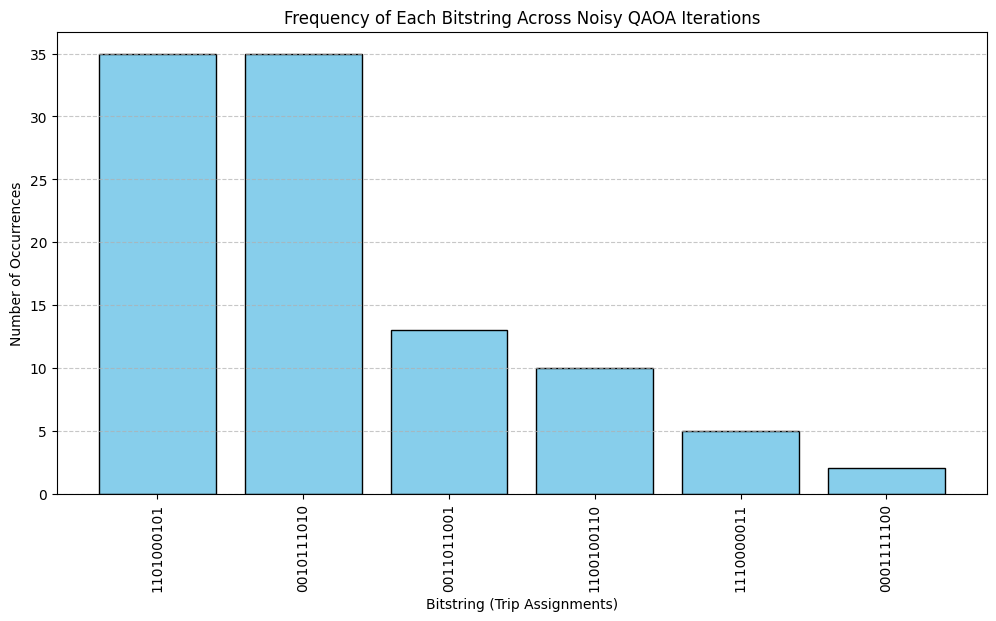

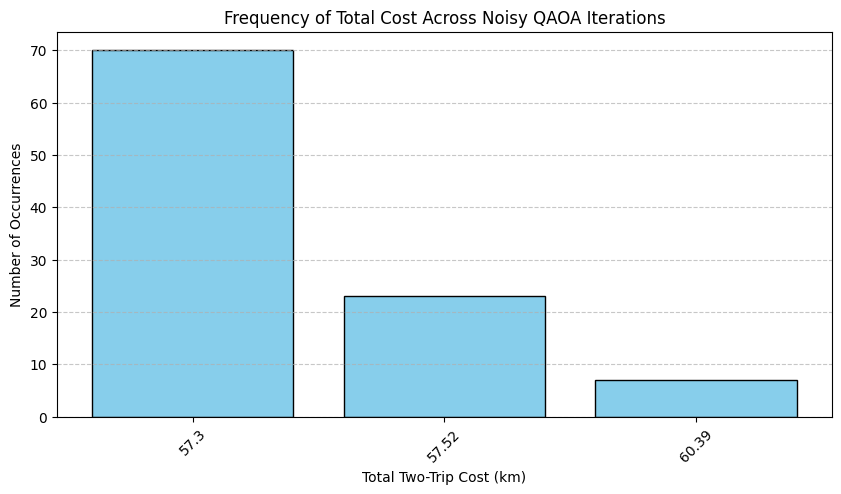

In [ ]:

import numpy as np
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer.primitives import Sampler
# from queuebo_qaoa_full_two_trips import QueueBoOptimizer, postprocess_qaoa_counts  # import your class

# -------------------------
# Setup noisy simulator
# -------------------------
# Depolarizing noise for 1-qubit and 2-qubit gates
noise_model = NoiseModel()
error_1q = depolarizing_error(0.01, 1)  # 1% single-qubit depolarizing
error_2q = depolarizing_error(0.05, 2)  # 5% two-qubit depolarizing
noise_model.add_all_qubit_quantum_error(error_1q, ['rx', 'ry', 'rz', 'h'])
noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])

# Create noisy simulator
simulator = AerSimulator(noise_model=noise_model, shots=1024)

# Instantiate Sampler WITHOUT backend
# sampler = Sampler()



# -------------------------
# Run noisy QAOA multiple times
# -------------------------
def run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=10):
    optimizer = QueueBoOptimizer(cost_matrix)
    all_results = []

    for itr in range(iterations):
        print(f"\n=== Iteration {itr + 1}/{iterations} ===")
        # Use your existing QAOA solver but replace Sampler with noisy one
        Q = optimizer.build_qubo_two_trips(P_assign=1000.0, P_cap=500.0)
        hamiltonian, const = optimizer.qubo_to_ising(Q)

        # Create QAOA
        from qiskit_algorithms.minimum_eigensolvers import QAOA
        from qiskit_algorithms.optimizers import COBYLA

        optimizer_algo = COBYLA(maxiter=maxiter)
        # sampler = Sampler(backend=simulator)
        sampler = Sampler()  # just Sampler()
        qaoa = QAOA(sampler=sampler, optimizer=optimizer_algo, reps=reps)
        result = qaoa.compute_minimum_eigenvalue(operator=hamiltonian)

        # Build ansatz and sample
        try:
            qc = qaoa.ansatz.assign_parameters(result.optimal_parameters)
        except Exception:
            qc = qaoa.ansatz.bind_parameters(result.optimal_parameters)

        # 3. Run your circuit using the simulator as backend
        job = sampler.run([qc], backend=simulator)
        qc_counts = job.result().quasi_dists[0]
        counts = job.result().quasi_dists[0]

        # Postprocess
        res = postprocess_qaoa_counts(counts, cost_matrix, optimizer.n_patients, max_stops=3)
        all_results.append(res)

    return all_results

# -------------------------
# Demo run
# -------------------------
if __name__ == "__main__":
    cost_matrix = np.array([
        [0.0, 8.63, 11.5, 9.45, 10.85, 9.67],
        [14.19, 0.0, 2.36, 10.92, 9.24, 9.43],
        [17.78, 7.75, 0.0, 11.81, 10.12, 10.48],
        [11.86, 19.67, 15.66, 0.0, 11.57, 11.54],
        [7.34, 12.17, 10.05, 4.07, 0.0, 5.93],
        [9.27, 9.4, 12.27, 7.32, 8.72, 0.0]
    ])

    results = run_noisy_qaoa(cost_matrix, reps=2, maxiter=100, iterations=100)



# Plot the result of noise


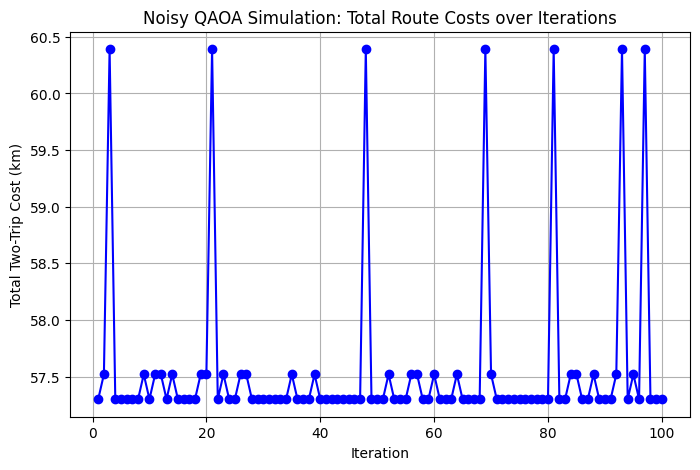

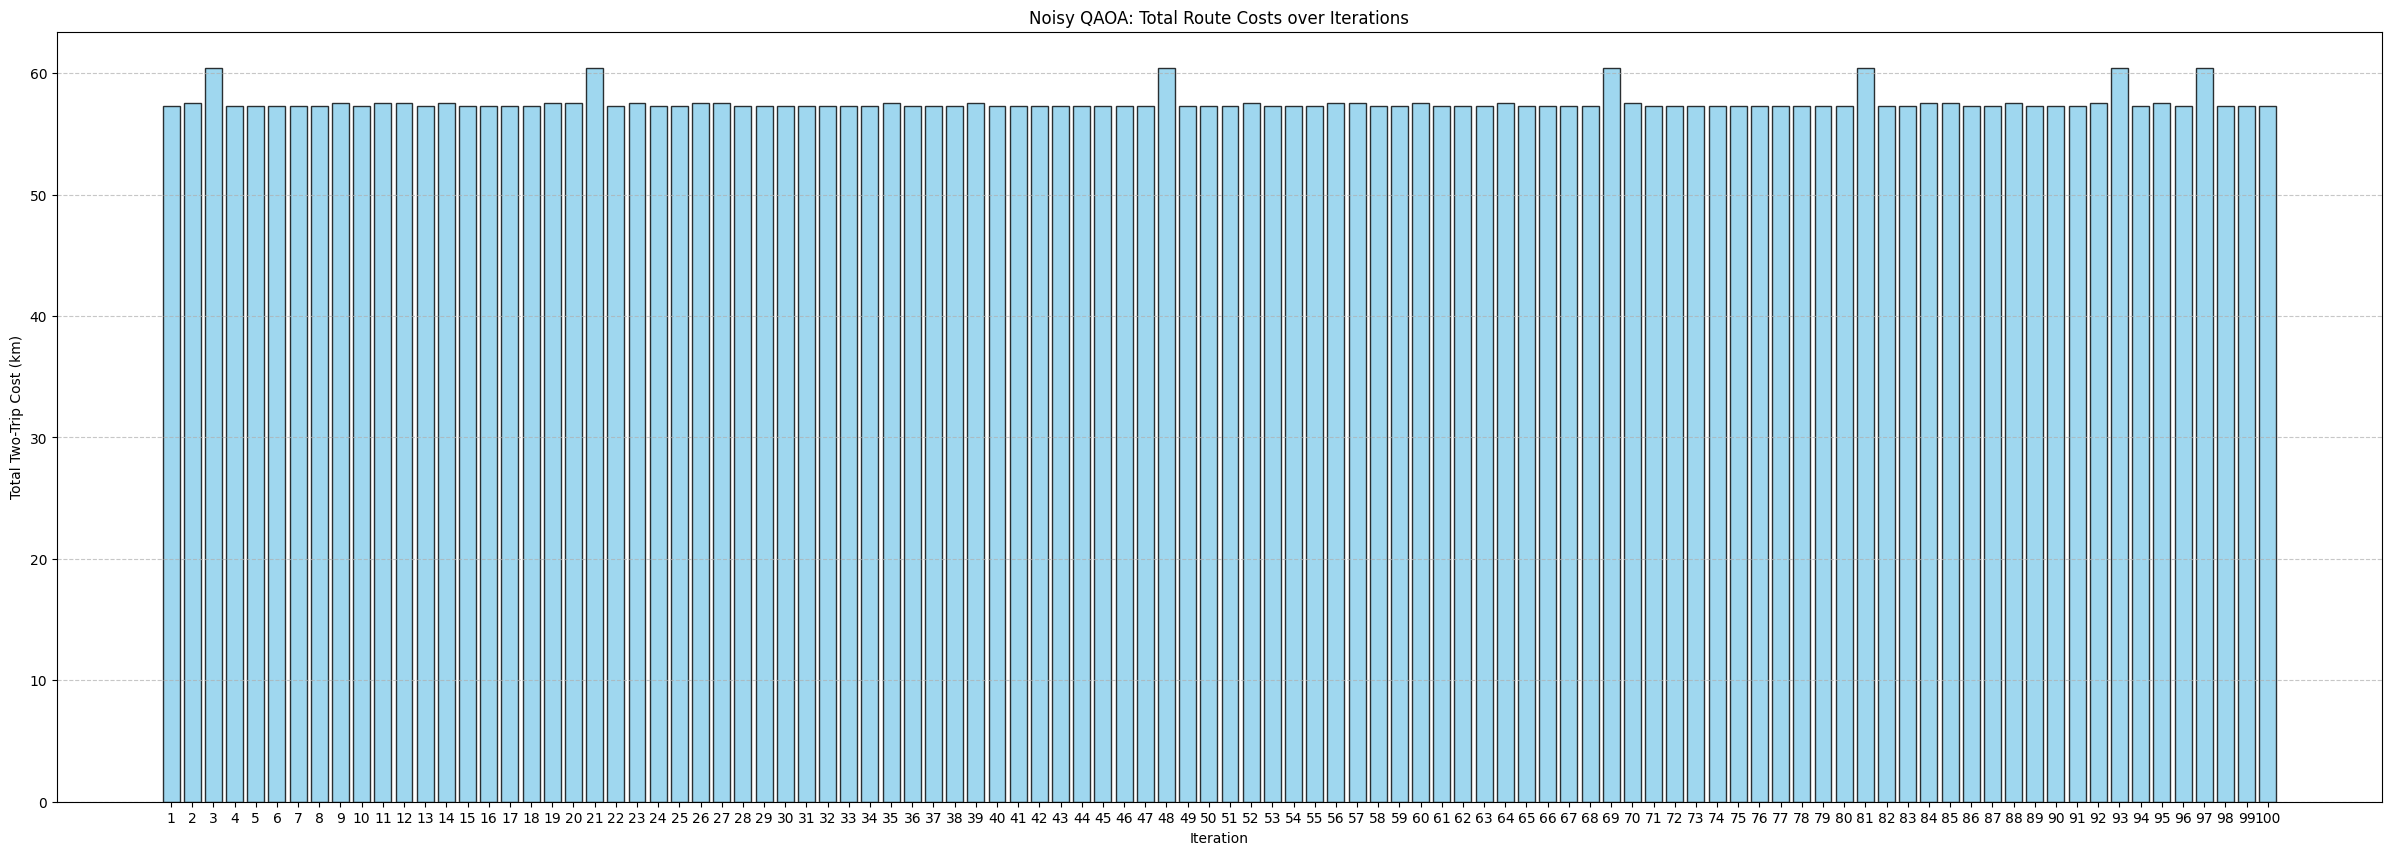

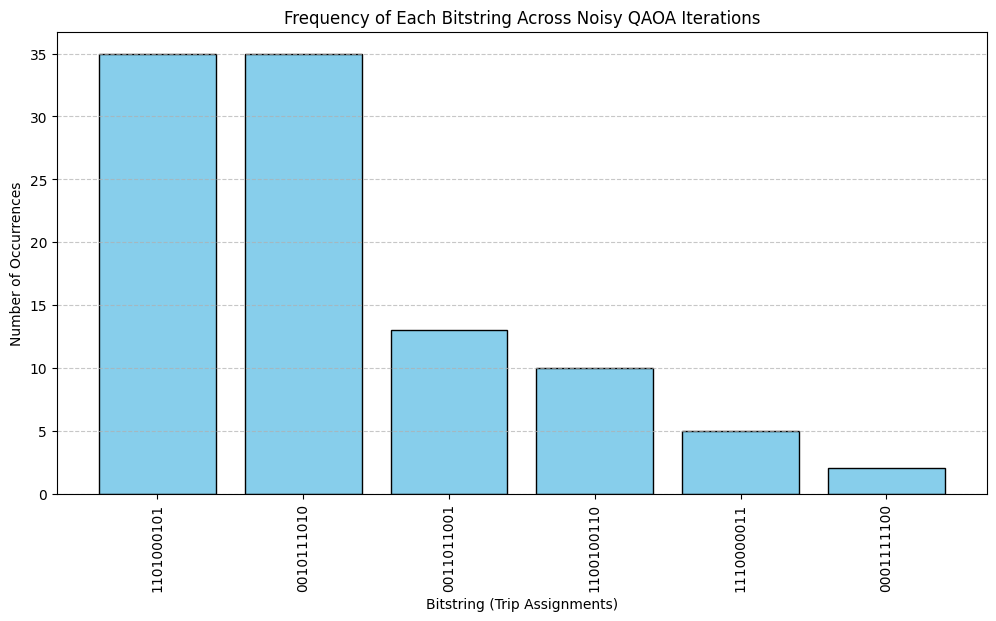

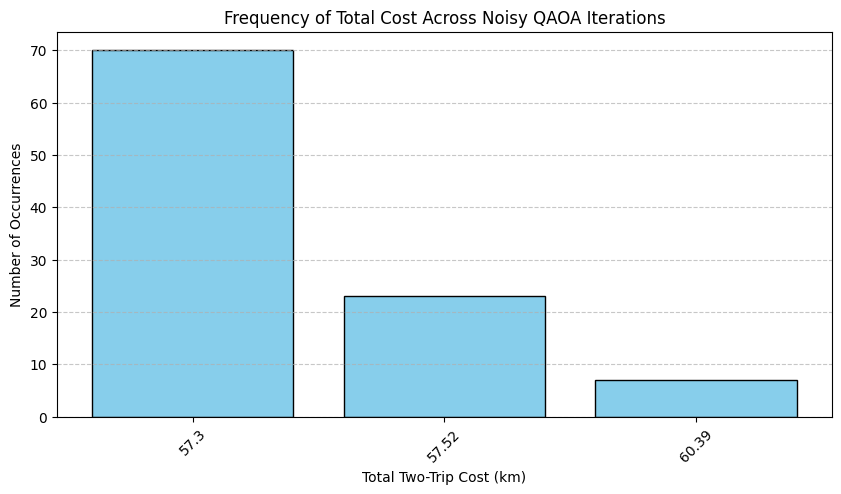

In [ ]:
import matplotlib.pyplot as plt

# -------------------------
# Plot total costs in km
# -------------------------
total_costs = [r["total_cost"] for r in results]
iterations = list(range(1, len(total_costs) + 1))

plt.figure(figsize=(8,5))
plt.plot(iterations, total_costs, marker='o', linestyle='-', color='b')
plt.xlabel("Iteration")
plt.ylabel("Total Two-Trip Cost (km)")
plt.title("Noisy QAOA Simulation: Total Route Costs over Iterations")
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

# iterations = list(range(1, len(total_costs) + 1))  # x-axis: iteration numbers

plt.figure(figsize=(30,10))
plt.bar(iterations, total_costs, color='skyblue', edgecolor='black', alpha=0.8)
plt.xlabel("Iteration")
plt.ylabel("Total Two-Trip Cost (km)")
plt.title("Noisy QAOA: Total Route Costs over Iterations")
plt.xticks(iterations)  # show iteration numbers on x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


from collections import Counter

# `all_results` is the list of results from 10 iterations:
# each element has res["bitstring"]

bitstrings = [r["bitstring"] for r in results]  # collect all bitstrings
counts = Counter(bitstrings)                     # count frequency of each bitstring

# Sort by frequency for better plotting
sorted_items = sorted(counts.items(), key=lambda x: x[1], reverse=True)
labels, frequencies = zip(*sorted_items)

plt.figure(figsize=(12,6))
plt.bar(labels, frequencies, color='skyblue', edgecolor='black')
plt.xlabel("Bitstring (Trip Assignments)")
plt.ylabel("Number of Occurrences")
plt.title("Frequency of Each Bitstring Across Noisy QAOA Iterations")
plt.xticks(rotation=90)  # rotate labels to fit
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# total_costs = [r["total_cost"] for r in results]

# Count frequency of each total cost (round to avoid tiny float differences)
rounded_costs = [round(c, 2) for c in total_costs]  # round to 2 decimals
counts = Counter(rounded_costs)

# Sort by cost for plotting
sorted_items = sorted(counts.items())
cost_values, frequencies = zip(*sorted_items)

plt.figure(figsize=(10,5))
plt.bar([str(c) for c in cost_values], frequencies, color='skyblue', edgecolor='black')
plt.xlabel("Total Two-Trip Cost (km)")
plt.ylabel("Number of Occurrences")
plt.title("Frequency of Total Cost Across Noisy QAOA Iterations")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/tmp/ipython-input-482639126.py:16: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  queuebo = QueueBo(cost_matrix)


Running QAOA 100 times...
Optimal value (energy): 5.0
Run 1/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 2/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 3/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 4/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 5/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 6/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 7/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 8/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 9/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 10/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 11/100 failed: 'str' object has no attribute 'items'
Optimal value (energy): 5.0
Run 12/100 failed: '

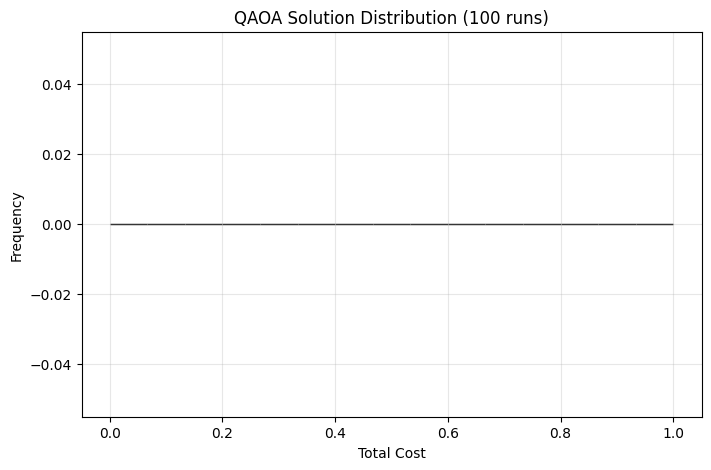

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example usage
if __name__ == "__main__":
    # Your cost matrix here (converted to numpy array)
    cost_matrix = np.array([
        [0.0, 8.63, 11.5, 9.45, 10.85, 9.67],
        [14.19, 0.0, 2.36, 10.92, 9.24, 9.43],
        [17.78, 7.75, 0.0, 11.81, 10.12, 10.48],
        [11.86, 19.67, 15.66, 0.0, 11.57, 11.54],
        [7.34, 12.17, 10.05, 4.07, 0.0, 5.93],
        [9.27, 9.4, 12.27, 7.32, 8.72, 0.0]
    ])

    queuebo = QueueBo(cost_matrix)

    print("Running QAOA 100 times...")
    costs = run_multiple_qaoa(queuebo, runs=100)

    # Plot histogram of results
    plt.figure(figsize=(8,5))
    plt.hist(costs, bins=15, color="skyblue", edgecolor="black")
    plt.xlabel("Total Cost")
    plt.ylabel("Frequency")
    plt.title("QAOA Solution Distribution (100 runs)")
    plt.grid(alpha=0.3)
    plt.show()


In [ ]:
import qiskit
print(qiskit.__version__)


1.2.4
